In [1]:
import sys
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib.pyplot as plt
import numpy as np
import ot
import time
import numba
import torch
parent_path='/home/baly/projects/sliced_opt'
os.chdir(parent_path)
print(parent_path)
from sopt.library import *
from sopt.lib_ot import *   
import pot1d 


/home/baly/projects/sliced_opt


In [ ]:
#test1
Lambda_list=np.array([20,100]).astype(np.float64)
k=10
print('start')
#n_list=np.array([1e2,1e3,2e3,4e3,5e3,6e3,7e3,8e3,9e3,1e4,2e4,3e4,4e4],dtype=np.int64)
n_list=np.arange(int(1e3),12000,step=500)
N=len(n_list)
D=len(Lambda_list)
time_lp_list=np.zeros((N,D,k))
time_new_list=np.zeros((N,D,k))
time_new_C_list=np.zeros((N,D,k))
time_sinkhorn_list=np.zeros((N,D,k))
time_pot_list=np.zeros((N,1,k))

for (ni,n) in enumerate(n_list):
    m=n #+1000
    print('n',n)
    print('m',m)
    mu=np.ones(n,dtype=np.float64)
    nu=np.ones(m,dtype=np.float64)
    for i in range (k):
        X=np.random.uniform(-20,20,n).astype(np.float64)
        Y=np.random.uniform(-20,20,m).astype(np.float64)
        
        X1=X.copy()
        Y1=Y.copy()
        start_time = time.time()
        X1.sort()
        Y1.sort()
        M=cost_matrix(X1,Y1)
        pot(M) #,verbose=False,plots=False)
        end_time = time.time()
        time_pot_list[ni,0,i]=end_time-start_time
        #print('ours numba done')
            
        for (j,Lambda) in enumerate(Lambda_list):
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            X1.sort()
            Y1.sort()
            M=cost_matrix(X1,Y1)
            obj,phi,psi,piRow,piCol=solve_opt(M,Lambda) #,verbose=False,plots=False)
            end_time = time.time()
            time_new_list[ni,j,i]=end_time-start_time
            
            
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            X1.sort()
            Y1.sort()
            obj,phi,psi,piRow,piCol=pot1d.solve(X1,Y1,Lambda) #,verbose=False,plots=False)
            end_time = time.time()
            time_new_C_list[ni,j,i]=end_time-start_time
                
            numItermax=int(200*n*np.log(n))
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            M=cost_matrix(X1,Y1)
            cost,gamma=opt_lp(mu,nu,M,Lambda,numItermax)
            end_time = time.time()
            time_lp_list[ni,j,i]=end_time-start_time
                
            X1=X.copy()
            Y1=Y.copy()
            reg=np.float32(max(Lambda/40,0.1))
            numItermax=int(200*n*np.log(n))
            start_time=time.time()
            M=cost_matrix(X1,Y1)
            sinkhorn_knopp_opt(mu,nu,M,Lambda,reg,numItermax=numItermax)
            end_time = time.time()
            time_sinkhorn_list[ni,j,i]=end_time-start_time
    time_list={}
    time_list['n_list']=n_list
    time_list['lp']=time_lp_list 
    time_list['new']=time_new_list
    time_list['new_C']=time_new_C_list
    time_list['sinkhorn']=time_sinkhorn_list
    time_list['pot']=time_pot_list

    torch.save(time_list,'experiment/performance_test/result/time_list_uniform.pt')

start
n 1000
m 1000
n 1500
m 1500
n 2000
m 2000
n 2500
m 2500
n 3000
m 3000
n 3500
m 3500
n 4000
m 4000
n 4500
m 4500
n 5000
m 5000
n 5500
m 5500


In [ ]:
start_n=1500
end_n=10000
device='cpu'
step=500
k=10
n_list=range(start_n,end_n,step)[1:]
fig = plt.figure()
ax = plt.subplot(111)
time_list=torch.load('experiment/test/results/time_list_uniform.pt')
time_pot_list=time_list['pot']
time_v2_list=time_list['v2']
time_v2_a_list=time_list['v2_a']
time_lp_list=time_list['lp']
time_new_list=time_list['new']
time_sinkhorn_list=time_list['sinkhorn']


plt.semilogy(n_list,time_pot_list[1:],'orange',label='partial OT')
for j in range(2):
#    plt.semilogy(n_list,time_v2_list[j][1:],label='ours,$\lambda=$'+str(Lambda_list[j]))
    plt.loglog(n_list,time_sinkhorn_list[j][1:],'green',label='Sinkhorn,$\lambda=$'+str(Lambda_list[j]))
    plt.loglog(n_list,time_lp_list[j][1:],'red',label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    plt.loglog(n_list,time_new_list[j][1:],'blue',linewidth=0.7,label='ours, $\lambda=$'+str(Lambda_list[j]))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.20),
          fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
plt.savefig('experiment/test/results/time_uniform_32.png',format='png',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

In [97]:
time_list=torch.load('experiment/performance_test/results/time_list_numba.pt')
n_list=time_list['n_list']
time_pot_list=time_list['pot'].mean(2)
time_lp_list=time_list['lp'].mean(2)
time_new_list=time_list['new'].mean(2)
time_new_C_list=time_list['new_C'].mean(2)
time_sinkhorn_list=time_list['sinkhorn'].mean(2)

def slop_loglog(time_list,n_list):
    N=len(time_list)
    log_time_list=np.log(time_list)
    log_n_list=np.log(n_list)
    A = np.vstack((log_n_list,np.ones(N))).T
    y = log_time_list.reshape(N,1)    
    # Direct least square regression
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    return alpha[0]  

    
    # for i in range(N-1):
    #     slop_list[i]=(np.log(time_list[i+1])-np.log(time_list[i]))/(np.log(n_list[i+1])-np.log(n_list[i]))
    # return slop_list,slop_list.mean(0)

# print slops of all the time:
for j in range(2):
    print('$\lambda=',Lambda_list[j])
    print('slop of lp is ',slop_loglog(time_lp_list[:,j],n_list))
    print('slop of ours is ',slop_loglog(time_new_list[:,j],n_list))
    print('slop of sinkhorn is ',slop_loglog(time_sinkhorn_list[:,j],n_list))
    #print('slop of pot is ',slop_loglog(time_pot_list[:,0],n_list))
    

$\lambda= 10.0
slop of lp is  [2.92182781]
slop of ours is  [2.40377569]
slop of sinkhorn is  [2.10946864]
slop of pot is  [1.70333075]
$\lambda= 100.0
slop of lp is  [2.797918]
slop of ours is  [1.60517679]
slop of sinkhorn is  [2.23232268]
slop of pot is  [1.70333075]


In [ ]:

time_list=torch.load('experiment/performance_test/results/time_list_numba.pt')
time_pot_list=time_list['pot'].mean(2)
time_lp_list=time_list['lp'].mean(2)
time_new_list=time_list['new'].mean(2)
time_new_C_list=time_list['new_C'].mean(2)
time_sinkhorn_list=time_list['sinkhorn'].mean(2)
# start_n=1500
# end_n=10000
# device='cpu'
# step=500
# k=10

# start_n=1500
# end_n=10000
# step=500
# k=2
             
fig = plt.figure()
ax = plt.subplot(111)

ax.loglog(n_list,time_pot_list[:],'green',label='partial OT')
for j in range(2):
    ax.loglog(n_list,time_sinkhorn_list[:,j],'red',label='Sinkhorn,$\lambda=$'+str(Lambda_list[j]))
    ax.loglog(n_list,time_lp_list[:,j],'black',label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    #ax.loglog(n_list,time_new_list[j],'orange',label='ours, $\lambda=$'+str(Lambda_list[j]))
    ax.loglog(n_list,time_new_C_list[:,j],'orange',label='ours,C, $\lambda=$'+str(Lambda_list[j]))
#box = ax.get_position()
ax.legend(bbox_to_anchor=(0.95,1.0))
#ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
#ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.23),
       #   fancybox=True, shadow=True, ncol=3)
ax.set_xlabel('n: size of X')
ax.set_ylabel("wall time")
plt.savefig('experiment/reviewer/result/time_plot.pdf',format='pdf',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

In [16]:
@nb.njit(['(float64[:])(float64[:],float64[:],int64)'],fastmath=True)
def Gaussian_mixture(mu_list, variance_list,n):
    N=mu_list.shape[0]
    indices=np.random.randint(0,N,n)
    X=np.zeros(n)
    for i in range(n):
        X[i]=np.random.normal(mu_list[indices[i]],variance_list[indices[i]])
    return X

# @nb.njit(['(float32[:])(float32[:],float32[:],int64)'],fastmath=True)
# def Gaussian_mixture_32(mu_list, variance_list,n):
#     N=mu_list.shape[0]
#     indices=np.random.randint(0,N,n)
#     X=np.zeros(n,dtype=np.float32)
#     for i in range(n):
#         X[i]=np.float32(np.random.normal(mu_list[indices[i]],variance_list[indices[i]]))
#     return X


    
    

In [17]:
mu1=np.linspace(-4,4,5)
mu2=np.linspace(-5,5,6)
var1=np.ones(5)
var2=np.ones(6)
X=Gaussian_mixture(mu1,var1,10)
print(X)

[ 5.43949762 -0.95486728  1.48640772 -0.21362046 -0.00693473 -1.63088248
  2.24904571  6.23082783 -1.03992554  0.27571546]


In [4]:
#test2
mean1=np.linspace(-4,4,5)
mean2=np.linspace(-5,5,6)
var1=np.ones(5)
var2=np.ones(6)

        
#test1
Lambda_list=np.array([20,100]).astype(np.float64)
k=5
print('start')
n_list=np.arange(int(1e3),int(2e4),step=1000)
N=len(n_list)
D=len(Lambda_list)
time_lp_list=np.zeros((N,D,k))
time_new_list=np.zeros((N,D,k))
time_new_C_list=np.zeros((N,D,k))
time_sinkhorn_list=np.zeros((N,D,k))
time_pot_list=np.zeros((N,1,k))

for (ni,n) in enumerate(n_list):
    m=n #+1000
    print('n',n)
    print('m',m)
    mu=np.ones(n,dtype=np.float64)
    nu=np.ones(m,dtype=np.float64)
    for i in range (k):
        X=Gaussian_mixture(mean1,var1,n) #.astype(np.float32) #np.random.uniform(-20,20,n).astype(np.float32)
        Y=Gaussian_mixture(mean2,var2,m) #.astype(np.float32) #np.random.uniform(-40,40,m).astype(np.float32)        
        X1=X.copy()
        Y1=Y.copy()
        start_time = time.time()
        M=cost_matrix(X1,Y1)
        pot(M) #,verbose=False,plots=False)
        end_time = time.time()
        time_pot_list[ni,0,i]=end_time-start_time
        #print('ours numba done')
            
        for (j,Lambda) in enumerate(Lambda_list):
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            X1.sort()
            Y1.sort()
            M=cost_matrix(X1,Y1)
            obj,phi,psi,piRow,piCol=solve_opt(M,Lambda) #,verbose=False,plots=False)
            end_time = time.time()
            time_new_list[ni,j,i]=end_time-start_time
            
            
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            X1.sort()
            Y1.sort()
            obj,phi,psi,piRow,piCol=pot1d.solve(X1,Y1,Lambda) #,verbose=False,plots=False)
            end_time = time.time()
            time_new_C_list[ni,j,i]=end_time-start_time
                
            numItermax=int(200*n*np.log(n))
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            M=cost_matrix(X1,Y1)
            cost,gamma=opt_lp(mu,nu,M,Lambda,numItermax)
            end_time = time.time()
            time_lp_list[ni,j,i]=end_time-start_time
                
            X1=X.copy()
            Y1=Y.copy()
            reg=np.float32(max(Lambda/40,0.1))
            numItermax=int(200*n*np.log(n))
            start_time=time.time()
            M=cost_matrix(X1,Y1)
            sinkhorn_knopp_opt(mu,nu,M,Lambda,reg,numItermax=numItermax)
            end_time = time.time()
            time_sinkhorn_list[ni,j,i]=end_time-start_time
    time_list={}
    time_list['n_list']=n_list
    time_list['lp']=time_lp_list 
    time_list['new']=time_new_list
    time_list['new_C']=time_new_C_list
    time_list['sinkhorn']=time_sinkhorn_list
    time_list['pot']=time_pot_list

    torch.save(time_list,'experiment/performance_test/result/time_list_Gaussian.pt')
    

start
n 1500
m 2500


TypeError: too many arguments: expected 1, got 2

In [37]:
time_sinkhorn_list

[[0.1151350975036621,
  0.21945080757141114,
  0.4094530582427979,
  1.0383500576019287,
  1.9707772731781006,
  3.0151814460754394,
  5.923446941375732,
  14.621810913085938,
  27.42362961769104,
  37.30857934951782,
  29.938614892959595,
  27.163487720489503,
  19.23037395477295,
  17.647161769866944,
  22.659733724594116,
  22.345075798034667,
  21.921456384658814],
 [0.08024487495422364,
  0.15455927848815917,
  0.27326092720031736,
  0.4823433876037598,
  0.8247636318206787,
  1.1099267482757569,
  2.0573440551757813,
  4.082003402709961,
  7.284257459640503,
  9.868714141845704,
  12.999133491516114,
  16.27747497558594,
  19.23168902397156,
  22.64235725402832,
  26.595413494110108,
  29.34384951591492,
  35.1268087387085]]

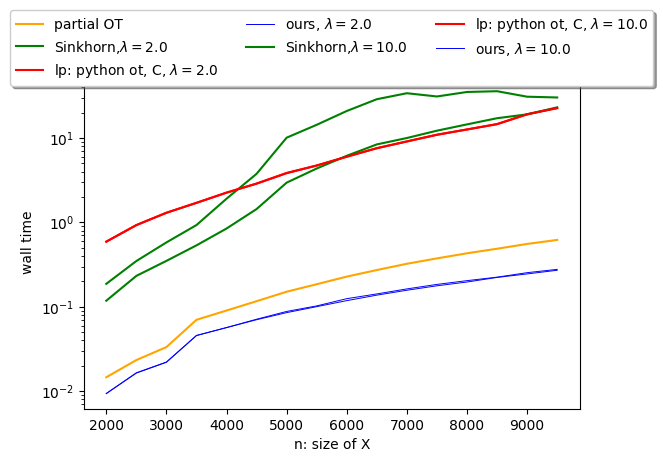

In [43]:
time_list=torch.load('experiment/test/results/time_list_numba_gaussian.pt')
time_pot_list=time_list['pot']
time_v2_list=time_list['v2']
time_v2_a_list=time_list['v2_a']
time_lp_list=time_list['lp']
time_new_list=time_list['new']
time_sinkhorn_list=time_list['sinkhorn']

start_n=1500
end_n=10000
device='cpu'
step=500
k=10
n_list=range(start_n,end_n,step)[1:]
fig = plt.figure()
ax = plt.subplot(111)

plt.semilogy(n_list,time_pot_list[1:],'orange',label='partial OT')
for j in range(2):
#    plt.semilogy(n_list,time_v2_list[j][1:],label='ours,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_sinkhorn_list[j][1:],'green',label='Sinkhorn,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_lp_list[j][1:],'red',label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_new_list[j][1:],'blue',linewidth=0.7,label='ours, $\lambda=$'+str(Lambda_list[j]))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.22),
          fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
plt.savefig('experiment/test/results/time_gaussian_32.png',format='png',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

In [21]:
reg=max(Lambda/40,0.1)
start_time=time.time()
M=cost_matrix(X1,Y1)

print(mu.dtype)
print(nu.dtype)
print(M.dtype)
print(type(Lambda))
reg=np.float32(max(Lambda/40,0.1))

print(type(reg))
#sinkhorn_knopp_opt_32(mu,nu,M,Lambda,reg,numItermax=numItermax)
end_time = time.time()



float32
float32
float32
<class 'numpy.float32'>
0.1
<class 'numpy.float32'>


In [34]:
mu = np.array([.1, .2])
nu =np.array([.1, .1])
M = np.array([[0., 1.], [2., 3.]])
mass=0.1
reg=1.0
K=entropic_opt(mu,nu,M,mass,reg,1000000)
print(K)

[[0.06439143 0.02368828]
 [0.00871443 0.00320586]]


In [35]:
start=time.time()
for k in range(10):
#    A=np.random.rand(5000,3)
    B=np.random.rand(10000,3)
end=time.time()
print(end-start)
print('hello')

0.003829479217529297
hello


In [ ]:
start=time.time()
for k in range(10):
    A=np.random.rand(5000,3)
    B=np.random.rand(10000,3)
    cost_matrix_d(A,B)
end=time.time()
print(end-start)

In [64]:
@nb.njit(['float32[:,:](float32[:,:],float32[:,:])'],fastmath=True)
def cost_matrix_d_321(X,Y):
    '''
    input: 
        X: (n,) float np array
        Y: (m,) float np array
    output:
        M: n*m matrix, M_ij=c(X_i,Y_j) where c is defined by cost_function.
    
    '''
    n,d=X.shape
    m=Y.shape[0]
    M=np.empty((n,m),dtype=np.float32) 
    for i in range(n):
        M[i]=np.sum(cost_function(X[i],Y),1)
    return M

In [65]:

start=time.time()
for i in range(10):
    X=np.random.rand(10000,3).astype(np.float32)
    Y=np.random.rand(12000,3).astype(np.float32)
    M1=cost_matrix_d_321(X,Y)
end=time.time()
print(end-start)

7.603938817977905


In [66]:
start=time.time()
for i in range(10):
    X=np.random.rand(10000,3).astype(np.float32)
    Y=np.random.rand(12000,3).astype(np.float32)
    M1=cost_matrix_d_32(X,Y)
end=time.time()
print(end-start)

11.36817717552185
